In [1]:
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Display 100 characters max within a cell
pd.set_option('max_colwidth',200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('text_emotion.csv')

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


It looks like there are lots of different characters, creative spelling and punctuation, misspellings, slang, new words or URLs. This needs to be fixed

## DATA WRANGLING, VISUALIZATION

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


There are no empty rows 

Lets see the group of sentiments on a graph

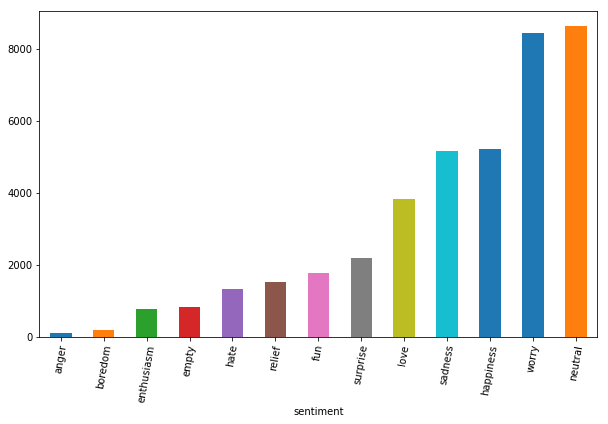

In [5]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [6]:
df.describe(include='object')

,sentiment,author,content
count,40000,40000,40000
unique,13,33871,39827
top,neutral,MissxMarisa,I just received a mothers day card from my lovely daughter wishing my a happy mothers day http://tr.im/kWK9
freq,8638,23,14


In [7]:
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

No missing values

In [8]:
df.content.duplicated().sum()

173

No duplicate values

Now lets see the distribution of emotions in the data set

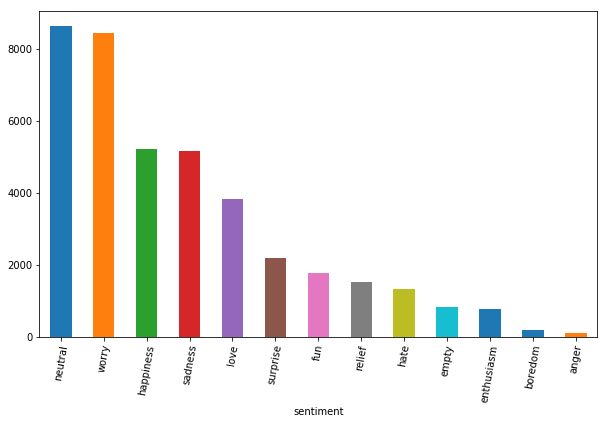

In [9]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [11]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [12]:
spacy_tok = spacy.load('en')
sample_review=df.content[8]
sample_review

'@charviray Charlene my love. I miss you'

In [13]:
parsed_review = spacy_tok(sample_review)
parsed_review

@charviray Charlene my love. I miss you

It looks like there are some html characters within the text such as:‘&amp’,’&quot’,etc. For decoding html to general text, beautiful soup can be used

In [14]:




wordpunctok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'

combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        quotRem = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        quotRem = souped
    stripped = re.sub(combined_pat, '', quotRem)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    words = [x for x  in wordpunctok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


df['Cleaned'] = df.content.apply(tweet_cleaner)

For removing the wgite spaces after the cleaning, i joined the letters with white spaces

In [15]:
df.Cleaned.head(10)

0                                             know was listenin to bad habit earlier and started freakin at his part
1                                                                 layin bed with headache ughhhh waitin on your call
2                                                                                     funeral ceremony gloomy friday
3                                                                                wants to hang out with friends soon
4                                              we want to trade with someone who has houston tickets but no one will
5                                             re pinging why did not you go to prom bc my bf did not like my friends
6    should be sleep but im not thinking about an old friend who want but he married now damn he wants me scandalous
7                                                                                                       hmmm is down
8                                                               

In [16]:
df.head()

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know was listenin to bad habit earlier and started freakin at his part
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed with headache ughhhh waitin on your call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",we want to trade with someone who has houston tickets but no one will


In [19]:

english_stops = set(stopwords.words('english'))

lemmatizer=WordNetLemmatizer()
stopword_list= stopwords.words('english')

df['Cleaned'] = df['Cleaned'].\
apply(lambda x: [lemmatizer.lemmatize(a) for a in 
                            [k for k in [l for l in [t.lower() for t in word_tokenize(x)] 
                                         if l.isalpha()] if k not in stopword_list]]).\
apply(lambda x: " ".join(x))

In [20]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['Cleaned'],
                                                    df['sentiment'],
                                                    test_size=.25, random_state=53)

In [21]:
count_vect2 = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train2 = count_vect2.fit_transform(X_train2)
count_vect_train2 = count_vect_train2.toarray()
count_vect_test2 = count_vect2.transform(X_test2)
count_vect_test2 = count_vect_test2.toarray()



In [22]:
logreg_CV2 = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV2.fit(count_vect_train2, y_train2)
y_pred_lr_CV2 = logreg_CV2.predict(count_vect_test2)
print('Accuracy :', metrics.accuracy_score(y_test2, y_pred_lr_CV2))

Accuracy : 0.2198


We have 13 emotions and we can categorize them in 3 sentiment categories: positive, neutral and negative

anger, boredom, hate, worry, sadness: Negative

happiness, fun, love, surprise, enthusiasm, relief: Positive

empty, neutral : Neutral

In [23]:
dfnew=df.copy()

In [24]:
dfnew.sentiment.replace(['anger','boredom','hate','worry','sadness','happiness','fun','love','surprise','enthusiasm','relief','empty','neutral'],
                    ['negative','negative','negative','negative','negative','positive','positive','positive','positive','positive','positive','neutral','neutral'],
                       inplace=True)

In [25]:
dfnew.head(20)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,pinging go prom bc bf like friend
6,1956968487,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want married damn want scandalous
7,1956968636,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm
8,1956969035,negative,nic0lepaula,@charviray Charlene my love. I miss you,charlene love miss
9,1956969172,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least friday


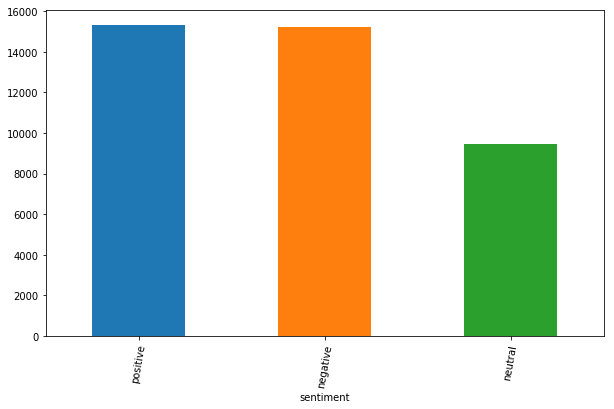

In [26]:
plt.subplots(figsize=(10,6))

dfnew.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [27]:

english_stops = set(stopwords.words('english'))

lemmatizer=WordNetLemmatizer()
stopword_list= stopwords.words('english')

dfnew['Cleaned'] = dfnew['Cleaned'].\
apply(lambda x: [lemmatizer.lemmatize(a) for a in 
                            [k for k in [l for l in [t.lower() for t in word_tokenize(x)] 
                                         if l.isalpha()] if k not in stopword_list]]).\
apply(lambda x: " ".join(x))

In [28]:
dfnew.head()

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one


## Train-Test Split

In [29]:


X_train, X_test, y_train, y_test = train_test_split(dfnew['Cleaned'],
                                                    dfnew['sentiment'],
                                                    test_size=.25, random_state=53)

## Count Vectirizing

In [30]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [31]:
vocab = count_vect.get_feature_names()

In [32]:
pd.DataFrame(count_vect_train, columns=vocab).head(10)

,able,absolutely,account,actually,add,afternoon,age,ago,agree,ah,...,yes,yesterday,yet,yo,young,youtube,yr,yum,yummy,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Lgistic Regression

In [33]:


logreg_CV = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

Accuracy : 0.5538


##  Linear SVC

In [34]:





Lsvc = LinearSVC()

Lsvc.fit(count_vect_train, y_train)

pred= Lsvc.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5733

In [35]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), min_df=0, max_df=1, use_idf=True)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
vocab = tfidf_vect.get_feature_names()
pd.DataFrame(np.round(tfidf_vect_train, 2), columns=vocab).head(10)
logreg_TV = LogisticRegression(class_weight='balanced', random_state=5)
logreg_TV.fit(tfidf_vect_train, y_train)
y_pred_lr_TV = logreg_TV.predict(tfidf_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_TV))
print (classification_report(y_test, y_pred_lr_TV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.3799
              precision    recall  f1-score   support

    negative       0.44      0.07      0.13      3829
     neutral       0.25      0.04      0.07      2389
    positive       0.38      0.91      0.54      3782

   micro avg       0.38      0.38      0.38     10000
   macro avg       0.36      0.34      0.24     10000
weighted avg       0.37      0.38      0.27     10000



## Lets try NLTK Vader for sentiment comparison

In [36]:

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [37]:
def sentiment_analyzer_scores(sentence):
    '''
    Evaluates polarity scores of a given sentence and prints the result.
    '''
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

analyzer = SentimentIntensityAnalyzer()

In [48]:

sentiments = []
compounds = []
sid = SentimentIntensityAnalyzer()
for i in dfnew.content:
    sentiment = sid.polarity_scores(i)
    if sentiment['compound']< -0.05:
        sentiments.append('negative')    
    elif sentiment['compound']> 0.05:
        sentiments.append('positive')
    else:
        sentiments.append('neutral')
    compounds.append(sentiment)
    
dfnew['vader'] = pd.DataFrame(sentiments)
dfnew['compound'] = compounds


In [49]:
dfnew.head(30)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
0,1956967341,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part,neutral,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1956967666,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1956967696,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,negative,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1956967789,czareaquino,wants to hang out with friends SOON!,want hang friend soon,positive,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1956968416,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one,neutral,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1956968477,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,pinging go prom bc bf like friend,negative,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1956968487,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want married damn want scandalous,negative,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1956968636,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1956969035,nic0lepaula,@charviray Charlene my love. I miss you,charlene love miss,negative,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1956969172,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least friday,negative,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [50]:
dfnew=dfnew[['tweet_id','author','content','Cleaned','sentiment','vader','compound']]
dfnew.head(30)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
0,1956967341,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part,neutral,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1956967666,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1956967696,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,negative,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1956967789,czareaquino,wants to hang out with friends SOON!,want hang friend soon,positive,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1956968416,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one,neutral,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1956968477,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,pinging go prom bc bf like friend,negative,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1956968487,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want married damn want scandalous,negative,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1956968636,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1956969035,nic0lepaula,@charviray Charlene my love. I miss you,charlene love miss,negative,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1956969172,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least friday,negative,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [51]:
for i in dfnew.index[0:30]:
    print(i)
    sentiment_analyzer_scores(dfnew.content[i])

0
@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[ {'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}
1
Layin n bed with a headache  ughhhh...waitin on your call... {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
2
Funeral ceremony...gloomy friday...----- {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
3
wants to hang out with friends SOON!---- {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}
4
@dannycastillo We want to trade with someone who has Houston tickets, but no one will. {'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}
5
Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends {'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}
6
I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous! {'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}
7
Hmmm. http://www.dj

Let's compare the sentiments in our data and the 'Vader' results

In [52]:
(dfnew.sentiment==dfnew.vader).mean()

0.543225

In [53]:
dfnew[dfnew.sentiment!=dfnew.vader].sample(10)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
9935,1962747221,LChows,The last day of the last time I visit my parents as an unmarried woman (85/21589) ( http://bit.ly/Mo0QN ),last day last time visit parent unmarried woman,positive,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
14974,1964699067,milestogogreg,"Shipwrecked all weekend license wasn't suspended, it got cancelled. Can't take the risk driving and no one lives near me",shipwrecked weekend license suspended got cancelled take risk driving one life near,negative,neutral,"{'neg': 0.171, 'neu': 0.651, 'pos': 0.178, 'compound': 0.0433}"
11827,1963368976,Kalan_blends,"@aneffie53 thx, I was aware, 2 day festival -multi bands - but GA I can't do any more. Must wait for a sit down concert",thx aware day festival multi band ga must wait sit concert,negative,positive,"{'neg': 0.0, 'neu': 0.824, 'pos': 0.176, 'compound': 0.431}"
16403,1965329545,krystapholyz,Change of plans. I am staying in Brandon. No Papaya Salad for me.,change plan staying brandon papaya salad,neutral,negative,"{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.296}"
21831,1694311534,MattJarryAstley,"Its a real shame that its not nice and sunny outside, it would of been nice to have another BBQ NVM....",real shame nice sunny outside would nice another bbq nvm,neutral,negative,"{'neg': 0.387, 'neu': 0.613, 'pos': 0.0, 'compound': -0.8441}"
34773,1752943605,rosemarieee,It's hard to tell But I think I'm right I hope.,hard tell think right hope,neutral,positive,"{'neg': 0.124, 'neu': 0.619, 'pos': 0.257, 'compound': 0.3612}"
22188,1694382308,whoa_liiva,"@tomatosponge hey, no we were second, kind sad, but it's ok guitar, guitar, guitar BBQ and good time what about you&gt;?",hey second kind sad ok guitar guitar guitar bbq good time,negative,positive,"{'neg': 0.134, 'neu': 0.586, 'pos': 0.28, 'compound': 0.6124}"
13985,1964292186,Factory_Boi,wants a new phone. ugh my b-day in 3 weeks ya'll,want new phone ugh day week ya,positive,negative,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.4215}"
18343,1965944182,360cookie,"@JVB Thanks, I just found a article that say i cannot join you because i am in the UK though",thanks found article say join uk though,negative,positive,"{'neg': 0.1, 'neu': 0.745, 'pos': 0.154, 'compound': 0.2528}"
39015,1753745242,deepakshenoy,"@sohamdas I agree - they will start - and I forgot, all that news is HT @sohamdas",agree start forgot news ht,neutral,positive,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}"
